# Building a clickbait classification pipeline

![Clickbait](http://www.ogilvy.com/wp-content/uploads/2015/10/166_main.jpg)

## Introduction

The aim of this workshop is to walk you through the process of taking data to a production machine learning classifier for text. You'll build a classifier to detect clickbait from the article text and eventually roll out the classifier into an app.

We'll be using
 - pandas for data wrangling
 - matplotlib for plotting
 - scikit-learn for feature engineering, model building, and model analysis
 - flask for building our web app
 - jupyter for getting stuff done

By the end of the workshop you'll understand the steps needed to build a basic text processing pipeline.

## Loading data and wrangling

You've been presented with tabular data in a `.csv` format. A natural choice for loading the data is pandas, which is based around tabular representations.

We'll load in the data and get a broad overview of the data.

In [1]:
import pandas as pd
%matplotlib inline 

In [2]:
df = pd.read_csv('./data/training_data.csv')
df.head(5)

,author,description,label,publishedAt,title
0,Julia Reinstein,"Trust no man, trust no brand. (This post will ...",1,NaN,The Definitive Guide To The Best April Fools’ ...
1,Natalya Lobanova,Not that anyone should need convincing of thei...,1,NaN,Literally Just 19 Pictures That Prove Hedgehog...
2,"Kat Angus, Jane Lytvynenko","You can only have one, eh?",1,NaN,"""Would You Rather"": Canadian Food Vs. Canadian..."
3,Ben Coleman,"""It's gonna rip my eyebrow off!""",1,NaN,"Guys Try The ""Most Painful"" Face Mask"
4,Ellie Bate,"No, your hair colour won't make a difference.",1,NaN,"Which ""Riverdale"" Family Do You Belong In?"


### Article details

An article contains:
 - **author** (string) - the article author's name
 - **description** (string) - a short description of the article
 - **label** (interger) - 1=clickbait 0=not clickbait
 - **publishedAt** (string) - a timestamp for the time of publication
 - **title** (string) - the title of the article

We can print the content of one article:

In [3]:
print(df['title'][1])
print('-----')
print(df['description'][1])
print('Published at:', df['publishedAt'][1])

Literally Just 19 Pictures That Prove Hedgehogs Are Ridiculously Cute
-----
Not that anyone should need convincing of their cuteness, tbh.
Published at: nan


### Basic statistics

Pandas makes it easy to inspect, plot, and transform our data. Pandas is easy to use but still has lots of functionality. When you can chain multiple functions together, you've become a pandas pro!

In [4]:
# Number of clickbait and non-clickbait articles
df['label'].value_counts()

0    706
1    519
Name: label, dtype: int64

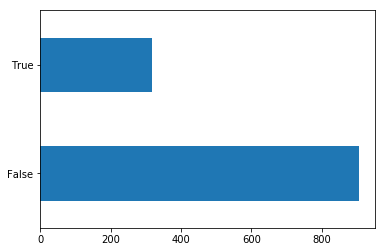

In [6]:
# Plotting the number of author fields that are Null
df['author'].isnull().value_counts().plot('barh')

In [7]:
# The number of characters in the description field
df['description'].apply(len).mean()

82.30285714285715

In [8]:
# Comparing the number of description characters in clickbait to news
df['description'].apply(len).groupby(df['label']).mean()

label
0    109.575071
1     45.204239
Name: description, dtype: float64

In [ ]:
# TEST YOUR KNOWLEDGE
# Can you write a one-liner to compute the number of clickbait articles
# written by each author? Hint: you might find the .sum() function helpful!

### Create the full content column

In [104]:
# df['full_content'] = (df.description + df.title)
df['full_content'] = (df.title)
df.head(1)

,author,description,label,publishedAt,title,full_content
0,Julia Reinstein,"Trust no man, trust no brand. (This post will ...",1,NaN,The Definitive Guide To The Best April Fools’ ...,The Definitive Guide To The Best April Fools’ ...


Nice work - have a panda

![panda](http://www.nathab.com/uploaded-files/carousels/TRIPS/Wild-China/Asia-Wild-China-4-panda.JPG)

---

# Text classification pipeline


Some important terminology:

<img src="http://tfwiki.net/mediawiki/images2/thumb/3/37/Optimusg1.jpg/350px-Optimusg1.jpg" alt="optimus" style="width:50px;" align="left"/> **TRANSFORMERS** - take some input data and transform it into another format. Often we want to transform textual data or image data into numerical data. We may also transform our input data into new features
<br/>
<br/>

<img src="http://www.kennyskiphire.co.uk/blog/wp-content/uploads/Wheelie-Bins.jpg" alt="bins" style="width:70px;" align="left"/> **CLASSIFIERS** - take some input data and classify the sample by assigning a label to the input data. In binary classification we often use the labels 1 and 0.
<br/>
<br/>

<img src="https://reichanjapan.files.wordpress.com/2016/02/mariogiftcard.png?w=230&h=335" alt="pipe" style="width:50px;" align="left"/> **PIPELINE** - consist of one or many transformer steps followed by a classifier. We can use pipelines to elegantly chain together operations and construct an easy to use interface. 

## Textual to numerical data (bag of words model) 

Our classifier isn't going to understand text like we can - we must create numerical data. A common approach to this is the bag of words model. 

For example - **Literally just 8 really really cute dogs** - transforms into the bag of words:

| Token | id | Count |
|---|---|---|
| cute | 0 |1 |
| dogs | 1 |1 |
| just | 2 | 1 |
| literally | 3 | 1 |
| really | 4 | 2 |

This is simply achieved with a scikit-learn `CountVectorizer`. There are two steps:
 - **Fit** the vectorizer, which populates all the tokens in the left hand column and assigns the numerical ids
 - **Transform** the data, which turns a sentence into it's bag of words representation
 
 Note that the bag of words representation of a sentence ignores the word order and dependencies between them.

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

Fitting the `CountVectorizer` learns the vocabulary

In [106]:
sentence = ["Literally just 8 really really cute dogs"]
vectorizer.fit(sentence)
print(vectorizer.vocabulary_) # dictionary of words and ids

{'cute': 0, 'really': 4, 'literally': 3, 'dogs': 1, 'just': 2}


We can then transform our textual to numerical data

In [107]:
vectorizer.transform(sentence).toarray()

array([[1, 1, 1, 1, 2]])

Note: we cannot transform textual data that is not in our learned vocabulary.

In [108]:
sentence = ["OMG 5 truly hilarious dogs 😂"]
vectorizer.transform(sentence).toarray()

array([[0, 1, 0, 0, 0]])

## Classifier

In the classification task, we take a single example (such as an article row) and decide which class it belongs to (e.g., clickbait or not clickbait). A standard approach to classification is to find a boundary that best seperates training examples according to their class. In the binary classification problem below, we've indicated a linear boundary that separates the data pretty well. Each sample is described by the number of times that word1 and word2 occur. In reality we will have many more words associated with each sample but the concept remains the same.

We determine this boundary using a Support Vector Machine. The SVM has two steps:
 - **Fit** we learn the boundary from labelled data
 - **Predict** we predict the classes of unlabelled data

![classify](images/svm-classify.png)

In [109]:
from sklearn.svm import LinearSVC
svc = LinearSVC()

Let's make up some samples.

In [110]:
bag_of_words = [
    [1, 5], [1, 4], [2, 6], [4, 2], [3, 4], [2, 1]
]
labels = [1, 1, 1, 0, 0, 0]

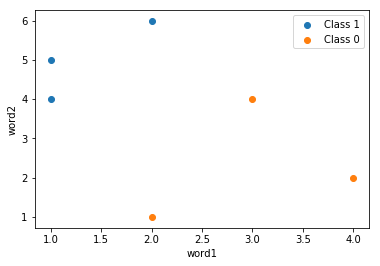

In [111]:
from utils.plotting import plot_2d_samples
plot_2d_samples(bag_of_words, labels)

Now we learn the boundary!

In [112]:
svc = svc.fit(bag_of_words, labels)

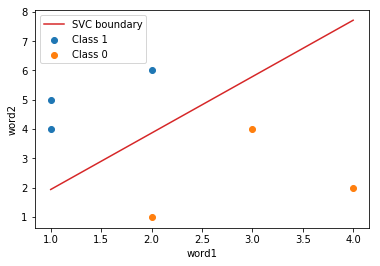

In [113]:
from utils.plotting import plot_2d_trained_svc
plot_2d_trained_svc(bag_of_words, labels, svc)

Once we have learned the boundary then we can predict the label of novel samples

In [114]:
svc.predict([[3, 1], [2,4]])

array([0, 1])

## Putting it all together in a pipeline

A pipeline consists of multiple transform steps and a final classification step. A pipeline is an easy way to wrap up all our transformations in one easy to use box. In general we use the following functions:
 - **Fit** to fit the transformers and classifier
 - **Predict** to transform data and predict it's label
 
Below is a detailed schematic of the data flow in the pipeline when we call these two methods.

![pipeobj](images/sklearn-pipeline.png)

We'll create a pipeline with two steps:
1. Transform textual data to a bag of words vector
2. Predict label from the bag of words vector

So the input of our pipeline is text data and the output is a label!

In [173]:
steps = (
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC())
)

In [174]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

**Congratulations!** You've built your first text classification pipeline.
![pipeygif](https://tinynin.files.wordpress.com/2012/01/warppipe-copy.gif)

## Training our pipeline on real data

Now that we know how the vectorizer and classifier work together to form a pipeline, we can train it on the real data. 

**Machine learning discipline 101**
 - Split your data into a training and testing set
 - NEVER look at your testing data. Hide it away. Save it for later. Lock it in a drawer!
 - Your training data helps you to fit your models and select one
 - Your testing data is used for final evaluation
 
Scikit-learn's train and test split shuffles our data and splits it into two sets. We can also use *stratified sampling* to ensure that both sets have the same distribution of labels.

In [223]:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(
    df,                # The dataset we want to split
    train_size=0.7,    # The proportional size of our training set
    stratify=df.label, # The labels are used for stratification
    random_state=400   # Use the same random state for reproducibility
)

In [118]:
training.head(5)

,author,description,label,publishedAt,title,full_content
343,Tom Vellner,DO NOT WATCH THE NEXT EPISODE WITHOUT ME.,1,2017-04-17T23:31:03Z,17 Things You Can't Get Away With When You Liv...,17 Things You Can't Get Away With When You Liv...
36,Christopher Hudspeth,Bacon and ham or chorizo and potatoes?,1,NaN,Create A Breakfast Burrito And We Can Tell Wha...,Create A Breakfast Burrito And We Can Tell Wha...
1023,Shafik Mandhai,A growing band of activists wants to take on p...,0,2017-04-19T05:31:21Z,In search of alternative media in France,In search of alternative media in France
765,Al Jazeera Investigative Unit,Al Jazeera investigation reveals how spyware v...,0,2017-04-10T11:24:03Z,How the 'dual-use' ruse is employed to sell sp...,How the 'dual-use' ruse is employed to sell sp...
213,Ellie Hall,"""A stranger restored my faith that no matter w...",1,NaN,People Are Loving This Story Of An American St...,People Are Loving This Story Of An American St...


In [119]:
print(len(training))
print(len(testing))

857
368


### Train

Now we're ready to train!

In [175]:
pipeline = pipeline.fit(training.full_content, training.label)

What? That was it?! 

That's right. You've just built a machine learning classifier for clickbait and it was that easy to train. Let's test it out:

In [222]:
pipeline.predict(["10 things you need to do..."])

array([1])

In [177]:
pipeline.predict(["French election polls show an early lead for Macron."])

array([0])

### Evaluate performance
Now let's see how well we perform on the test set.

In [215]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from utils.plotting import plot_confusion_matrix

def evaluate(pipeline, test_samples, test_labels, n=5):
    predicted_label = pipeline.predict(test_samples)

    print("Accuracy = {:.1f}%".format(
        accuracy_score(test_labels, predicted_label) * 100.0
    ))
    
    cm = confusion_matrix(test_labels, predicted_label)
    plot_confusion_matrix(cm, pipeline.classes_)
    
    wrong_predictions = [
        (true_label, pred_label, test_sample)
        for true_label, pred_label, test_sample in zip(test_labels, predicted_label, test_samples) 
        if true_label != pred_label
    ]
    
    print('true_label, pred_label, test_sample')
    print('\n')
    for wrong_prediction in wrong_predictions[:n]:
        print(wrong_prediction)
    

Accuracy = 98.1%
Confusion matrix, without normalization
[[211   1]
 [  6 150]]
true_label, pred_label, test_sample


(1, 0, "'Despite the tragedy of the earthquake and tsunami, it is still a place of serenity and peace.'\n20 Eerie Pictures Of Life After Nuclear Fallout")
(0, 1, 'Marching for science or scientists marching?\nWe need a march for science, but this is not the one')
(1, 0, 'Some of our recent favorites we’ve reviewed in the BuzzFeed Books newsletter.\n5 Great Books To Read In April')
(1, 0, 'The president said he made the decision to launch 59 missiles against Syria over a delicious dessert with the Chinese president.\nTrump Was Eating "The Most Beautiful Piece Of Chocolate Cake" When He Bombed Syria')
(1, 0, 'Michaella Surat, a Colorado State University student, was arrested for allegedly assaulting a police officer after the altercation.\nThis Video Appears To Show A Cop Slamming A 22-Year-Old Sorority Girl To The Ground')


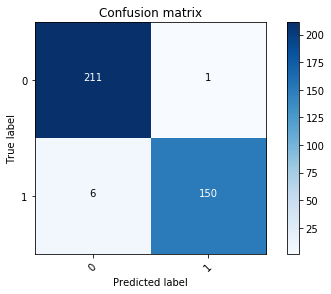

In [218]:
evaluate(pipeline, testing.full_content, testing.label)

### Add description

Accuracy = 98.1%
Confusion matrix, without normalization
[[211   1]
 [  6 150]]
true_label, pred_label, test_sample


(1, 0, "'Despite the tragedy of the earthquake and tsunami, it is still a place of serenity and peace.'\n20 Eerie Pictures Of Life After Nuclear Fallout")
(0, 1, 'Marching for science or scientists marching?\nWe need a march for science, but this is not the one')
(1, 0, 'Some of our recent favorites we’ve reviewed in the BuzzFeed Books newsletter.\n5 Great Books To Read In April')
(1, 0, 'The president said he made the decision to launch 59 missiles against Syria over a delicious dessert with the Chinese president.\nTrump Was Eating "The Most Beautiful Piece Of Chocolate Cake" When He Bombed Syria')
(1, 0, 'Michaella Surat, a Colorado State University student, was arrested for allegedly assaulting a police officer after the altercation.\nThis Video Appears To Show A Cop Slamming A 22-Year-Old Sorority Girl To The Ground')


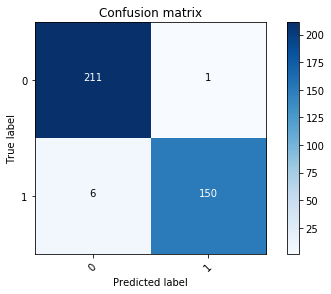

In [220]:
df['full_content'] = (df.description + "\n" + df.title)
training, testing = train_test_split(
    df,                # The dataset we want to split
    train_size=0.7,    # The proportinal size of our training set
    stratify=df.label, # The labels are used for stratification
    random_state=400   # Use the same random state for reproducibility
)
pipeline = pipeline.fit(training.full_content, training.label)
evaluate(pipeline, testing.full_content, testing.label)

### TfidfVectorizer Transformer

Accuracy = 97.6%
Confusion matrix, without normalization
[[209   3]
 [  6 150]]
true_label, pred_label, test_sample


(0, 1, 'Veeru Kohli now works to eradicate this form of slavery in Pakistan, home to about two million bonded labourers.\nVeeru Kohli: A bonded labourer who took on the Bhuttos')
(1, 0, "'Despite the tragedy of the earthquake and tsunami, it is still a place of serenity and peace.'\n20 Eerie Pictures Of Life After Nuclear Fallout")
(0, 1, 'Marching for science or scientists marching?\nWe need a march for science, but this is not the one')
(1, 0, 'Some of our recent favorites we’ve reviewed in the BuzzFeed Books newsletter.\n5 Great Books To Read In April')
(1, 0, 'The president said he made the decision to launch 59 missiles against Syria over a delicious dessert with the Chinese president.\nTrump Was Eating "The Most Beautiful Piece Of Chocolate Cake" When He Bombed Syria')


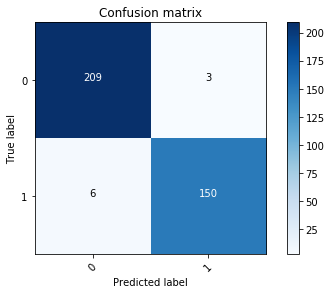

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer

steps = (
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
)

pipeline = Pipeline(steps)

pipeline = pipeline.fit(training.full_content, training.label)
evaluate(pipeline, testing.full_content, testing.label)

### Hyperparameters

When we constructed our `LinearSVC` and `CountVectorizer` we used the default model parameters. These additonal parameters (hyperparameters) can be chosen to improve our classifier by performing a grid search. A grid search trains a classifier on every combination of the parameters and analyses their performance. We can then pick the best one.

In [207]:
steps = (
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
)

pipeline = Pipeline(steps)

Some parameters we can fiddle:
 - stop_words - we can ignore certain words (the, a, it,...). scikit-learn has an 'english' stop word vocabulary we can use
 - ngram_range - in the above example we split sentences into words. We could also try pairs of words.
 - C - the SVM has a property C that performs regularisation
 
We set up our grid as a dictionary (note we must use the step names so that scikit learn knows which component we are fiddling with):

In [208]:
gs_params = {
    'vectorizer__stop_words': ['english', None],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [209]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(pipeline, gs_params, n_jobs=-1)
gs.fit(training.full_content, training.label)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=(('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tr...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)))),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'vectorizer__stop_words': ['english', None], 'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [210]:
print(gs.best_params_)

{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'classifier__C': 100}


In [211]:
pipeline = gs.best_estimator_

Accuracy = 98.1%
Confusion matrix, without normalization
[[211   1]
 [  6 150]]


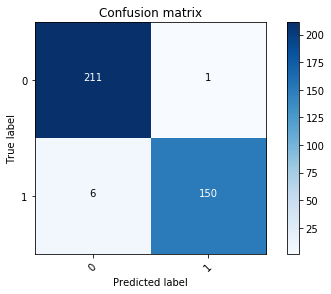

In [212]:
evaluate(pipeline, testing.full_content)

# Going into the wild

![hunger](https://ronanwills.files.wordpress.com/2015/06/vlcsnap-2015-06-11-23h05m49s76.png?w=625)

One excellent feature of scikit learn is that we can save our classifier using the pickle tool. We can load it later for
 - data analysis
 - data provenance
 - to share with somebody
 - to provide ML as a service (coming up)

In [68]:
filename = 'classifiers/clickbait_svc_v1'

In [69]:
import pickle
with open(filename, 'wb') as f:
    pickle.dump(pipeline, f)

# Congratulations

You've built a clickbait classifer. Head over to `advanced.ipynb` or look through the `webservice` directory to put your pipeline to use.

![gatsby](https://media.tenor.co/images/78f5d1acd72e8a66257ea671b4aefd5f/tenor.gif)
